In [19]:
import pandas as pd
import numpy as np
import json
import yaml
import scikit_posthocs as sp
from scipy import stats
import seaborn as sn
import pickle

from matplotlib import pyplot as plt

from scipy.stats import wilcoxon, friedmanchisquare, rankdata
from Orange.evaluation import compute_CD, graph_ranks

sn.set(rc={'figure.figsize':(23.4,16.54)})

In [2]:
def parser_method_dict(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]):
        row = yaml.safe_load(df.iloc[i].iloc[0])
        dataf.loc[i] = [np.trapz(row[j]) for j in row]
    #print(dataf)
    return dataf

In [3]:
def parser_method_dict_with_layers(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
        Note that df.iloc[0] has a dic e.g., {"layer1": [list of corr of bacth], "layer2": [list of corr of batch]}
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]): # loop over the number of batches
        row = yaml.safe_load(df.iloc[i].iloc[0]) # Get the batch result
        
        # p is the index of image, j is the layer_name, np.trapz computes the AUC
        dataf.loc[i] = [np.trapz([row[j][p] for j in row]) for p in range(batch)]
    return dataf

In [7]:
metrics =  [
    'Monotonicity Nguyen',
    'Local Lipschitz Estimate',
    'Faithfulness Estimate',
    'Faithfulness Correlation',
    'Avg-Sensitivity',
    'Random Logit',
    'Max-Sensitivity',
    'Sparseness', 
    'EffectiveComplexity',
    'Monotonicity Arya',
    'Complexity',
    'Pixel-Flipping',
    'Selectivity',
    'Model Parameter Randomisation'
]
                # ['SensitivityN': problem with implementation,
                #'Region Perturbation' seems to be same as region perturbation, 
                #'Continuity Test': Difficult to aggregate result, the paper just plot it
                #'Completeness' always returns False]
                # Nonsentitivity is removed

metrics_with_different_baselines = {
    'Faithfulness Estimate',
    'Faithfulness Correlation',
    'Monotonicity Arya',
    'Monotonicity Nguyen',
    'Pixel-Flipping',
    'Selectivity',
}
                
baselines = [
    'baseline_black',
    'baseline_mean',
    'baseline_random',
    'baseline_uniform',
    'baseline_white'
]
                
transform = {
    'Monotonicity Nguyen': lambda x: x,
    'Local Lipschitz Estimate': lambda x: -x, 
    'Faithfulness Estimate': abs,
    'Faithfulness Correlation': abs, 
    'Avg-Sensitivity': lambda x: -x,
    'Random Logit': lambda x: x,
    'Sparseness': lambda x: x,
    'EffectiveComplexity': lambda x: -x,
    'Nonsensitivity': lambda x: -x,
    'Pixel-Flipping': lambda x: x.apply(lambda row: - np.trapz(row), axis=1),
    'Max-Sensitivity': lambda x: -x,
    'Complexity': lambda x: -x, 
    "Selectivity": lambda x: -parser_method_dict(x),
    'Model Parameter Randomisation': lambda x: parser_method_dict_with_layers(x),
    'Monotonicity Arya': lambda x: x,
}

aggregate = {
    'Monotonicity Nguyen': lambda x: np.tanh(np.mean(np.arctanh(x))),
    'Local Lipschitz Estimate': np.mean,
    'Faithfulness Estimate': lambda x: np.tanh(np.mean(np.arctanh(x))),
    'Faithfulness Correlation': lambda x: np.tanh(np.mean(np.arctanh(x))),
    'Avg-Sensitivity': np.mean,
    'Random Logit': np.mean,
    'Max-Sensitivity': np.mean,
    'Sparseness': np.mean, 
    'EffectiveComplexity': np.mean,
    'Monotonicity Arya': np.mean,
    'Complexity': np.mean,
    'Pixel-Flipping': np.mean,
    'Selectivity': np.mean,
    'Model Parameter Randomisation': np.mean
}

methods = ['integratedgrad', 'smoothgrad', 'guidedbackprop', 'rise', 'gradcam',
           'scorecam', 'layercam', 'random', 'sobel', "gaussian", "polycam"]

model = "resnet50"
dataset = "imagenet"

dico_ranks = {}
alpha = 0.05 #Seuil de significativité

for metr in metrics: #metrics:
    if metr in metrics_with_different_baselines:
        for baseline in baselines:
            metr_with_baseline = f'{metr} with {baseline}'
            print(f"-- Metric: {metr_with_baseline}")
            scores = []
            for meth in methods:
                csv_name = f"csv/{meth}_{model}_{dataset}_{metr}_{baseline}.csv"
                df = pd.read_csv(csv_name, header = None)
                data = transform[metr](df).values.flatten()
                scores.append(-aggregate[metr](data))
            dico_ranks[metr_with_baseline] = rankdata(scores)
    elif metr == 'Model Parameter Randomisation':
        for baseline in ['bottom_up','top_down']:
            metr_with_baseline = f'{metr} with {baseline}'
            print(f"-- Metric: {metr_with_baseline}")
            scores = []
            for meth in methods:
                csv_name = f"csv/{meth}_{model}_{dataset}_{metr}_{baseline}.csv"
                df = pd.read_csv(csv_name, header = None)
                data = transform[metr](df).values.flatten()
                scores.append(-aggregate[metr](data))
            dico_ranks[metr_with_baseline] = rankdata(scores)
    else:
        print(f"-- Metric: {metr}")
        scores = []
        for meth in methods:
            csv_name = f"csv/{meth}_{model}_{dataset}_{metr}.csv"
            df = pd.read_csv(csv_name, header = None)
            data = transform[metr](df).values.flatten()
            scores.append(-aggregate[metr](data))                
        dico_ranks[metr] = rankdata(scores)

df_ranks = pd.DataFrame(dico_ranks, index= methods)
metrics_with_baselines = sorted(dico_ranks.keys())

-- Metric: Monotonicity Nguyen with baseline_black
-- Metric: Monotonicity Nguyen with baseline_mean
-- Metric: Monotonicity Nguyen with baseline_random
-- Metric: Monotonicity Nguyen with baseline_uniform
-- Metric: Monotonicity Nguyen with baseline_white
-- Metric: Local Lipschitz Estimate
-- Metric: Faithfulness Estimate with baseline_black
-- Metric: Faithfulness Estimate with baseline_mean
-- Metric: Faithfulness Estimate with baseline_random
-- Metric: Faithfulness Estimate with baseline_uniform
-- Metric: Faithfulness Estimate with baseline_white
-- Metric: Faithfulness Correlation with baseline_black
-- Metric: Faithfulness Correlation with baseline_mean
-- Metric: Faithfulness Correlation with baseline_random
-- Metric: Faithfulness Correlation with baseline_uniform
-- Metric: Faithfulness Correlation with baseline_white
-- Metric: Avg-Sensitivity
-- Metric: Random Logit
-- Metric: Max-Sensitivity
-- Metric: Sparseness
-- Metric: EffectiveComplexity
-- Metric: Monotonicity Ary

In [8]:
df_ranks

,Monotonicity Nguyen with baseline_black,Monotonicity Nguyen with baseline_mean,Monotonicity Nguyen with baseline_random,Monotonicity Nguyen with baseline_uniform,Monotonicity Nguyen with baseline_white,Local Lipschitz Estimate,Faithfulness Estimate with baseline_black,Faithfulness Estimate with baseline_mean,Faithfulness Estimate with baseline_random,Faithfulness Estimate with baseline_uniform,...,Pixel-Flipping with baseline_random,Pixel-Flipping with baseline_uniform,Pixel-Flipping with baseline_white,Selectivity with baseline_black,Selectivity with baseline_mean,Selectivity with baseline_random,Selectivity with baseline_uniform,Selectivity with baseline_white,Model Parameter Randomisation with bottom_up,Model Parameter Randomisation with top_down
integratedgrad,8.0,2.0,1.0,6.0,6.0,2.0,9.0,1.0,1.0,8.0,...,1.0,6.0,1.0,2.0,2.0,2.0,2.0,2.0,9.0,9.0
smoothgrad,4.0,5.0,5.0,4.0,4.0,4.0,6.0,2.0,2.0,4.0,...,8.0,8.0,5.0,4.0,3.0,3.0,3.0,4.0,2.0,2.0
guidedbackprop,9.0,9.0,9.0,9.0,9.0,1.0,10.0,10.0,10.0,10.0,...,10.0,10.0,2.0,3.0,4.0,4.0,4.0,3.0,11.0,11.0
rise,7.0,8.0,8.0,8.0,8.0,10.0,5.0,5.0,8.0,7.0,...,4.0,2.0,6.0,5.0,6.0,5.0,5.0,5.0,7.0,7.0
gradcam,2.0,3.0,3.0,2.0,2.0,6.0,1.0,4.0,4.0,1.0,...,3.0,1.0,10.0,11.0,11.0,10.0,11.0,11.0,4.0,3.0
scorecam,3.0,4.0,4.0,3.0,3.0,7.0,4.0,7.0,6.0,3.0,...,5.0,4.0,11.0,10.0,10.0,11.0,10.0,9.0,3.0,4.0
layercam,1.0,1.0,2.0,1.0,1.0,9.0,3.0,8.0,7.0,2.0,...,6.0,3.0,9.0,9.0,9.0,9.0,9.0,10.0,5.0,5.0
random,10.0,10.0,10.0,10.0,11.0,8.0,11.0,11.0,11.0,11.0,...,11.0,11.0,3.0,1.0,1.0,1.0,1.0,1.0,10.0,10.0
sobel,11.0,11.0,11.0,11.0,10.0,3.0,8.0,9.0,9.0,9.0,...,9.0,9.0,4.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0
gaussian,6.0,7.0,7.0,7.0,7.0,11.0,2.0,3.0,3.0,5.0,...,2.0,5.0,8.0,7.0,5.0,6.0,7.0,7.0,1.0,1.0


In [20]:
#with open('rankings_by_avg_aggreg.pickle', 'wb') as file:
#    pickle.dump(dico_ranks, file)

In [21]:
#with open('rankings_by_avg_aggreg.pickle', 'rb') as file:
#    dico_ranks = pickle.load(file)

In [10]:
tau_values = []
p_values = []

for metric_a in metrics_with_baselines:
    current_tau_values = []
    current_p_values = []
    for metric_b in metrics_with_baselines:
        tau, p_value = stats.kendalltau(dico_ranks[metric_a], dico_ranks[metric_b])
        current_tau_values.append(tau)
        current_p_values.append(p_value)
    tau_values.append(current_tau_values)
    p_values.append(current_p_values)

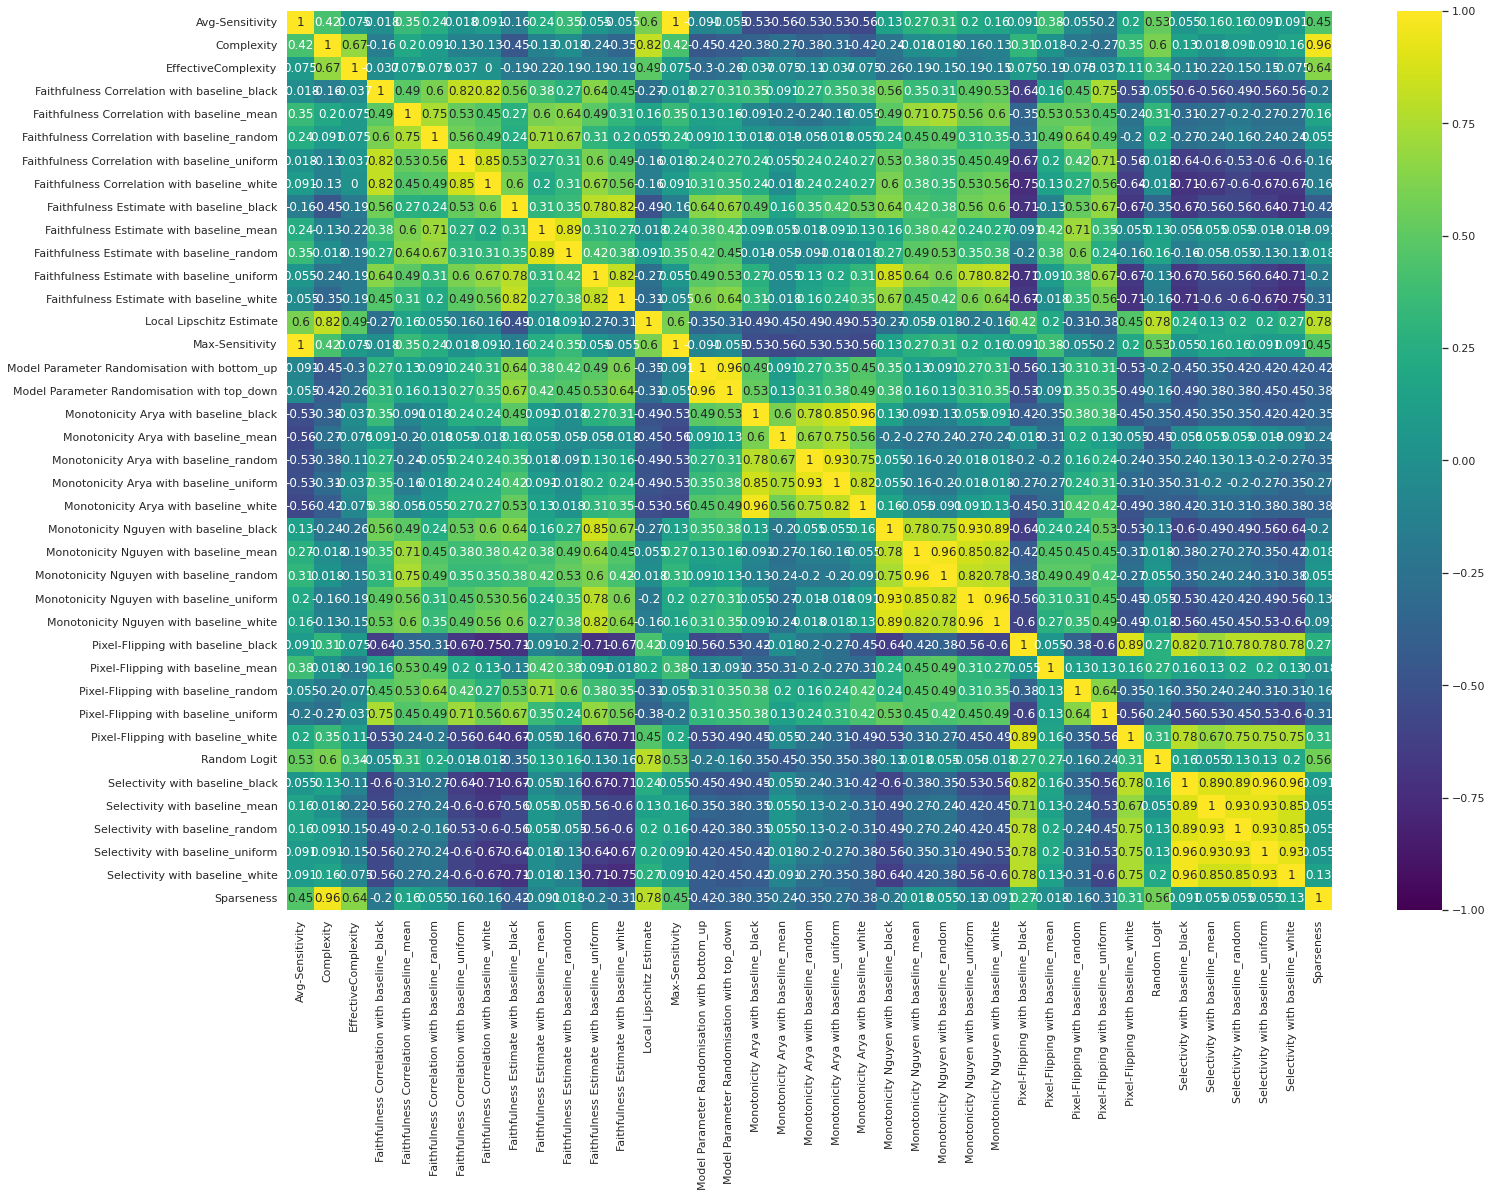

In [22]:
# Correlation Matrix
sn.heatmap(tau_values,
           annot=True,
           vmin=-1,
           vmax=1,
           xticklabels=metrics_with_baselines,
           yticklabels=metrics_with_baselines,
           cmap='viridis')
plt.show()

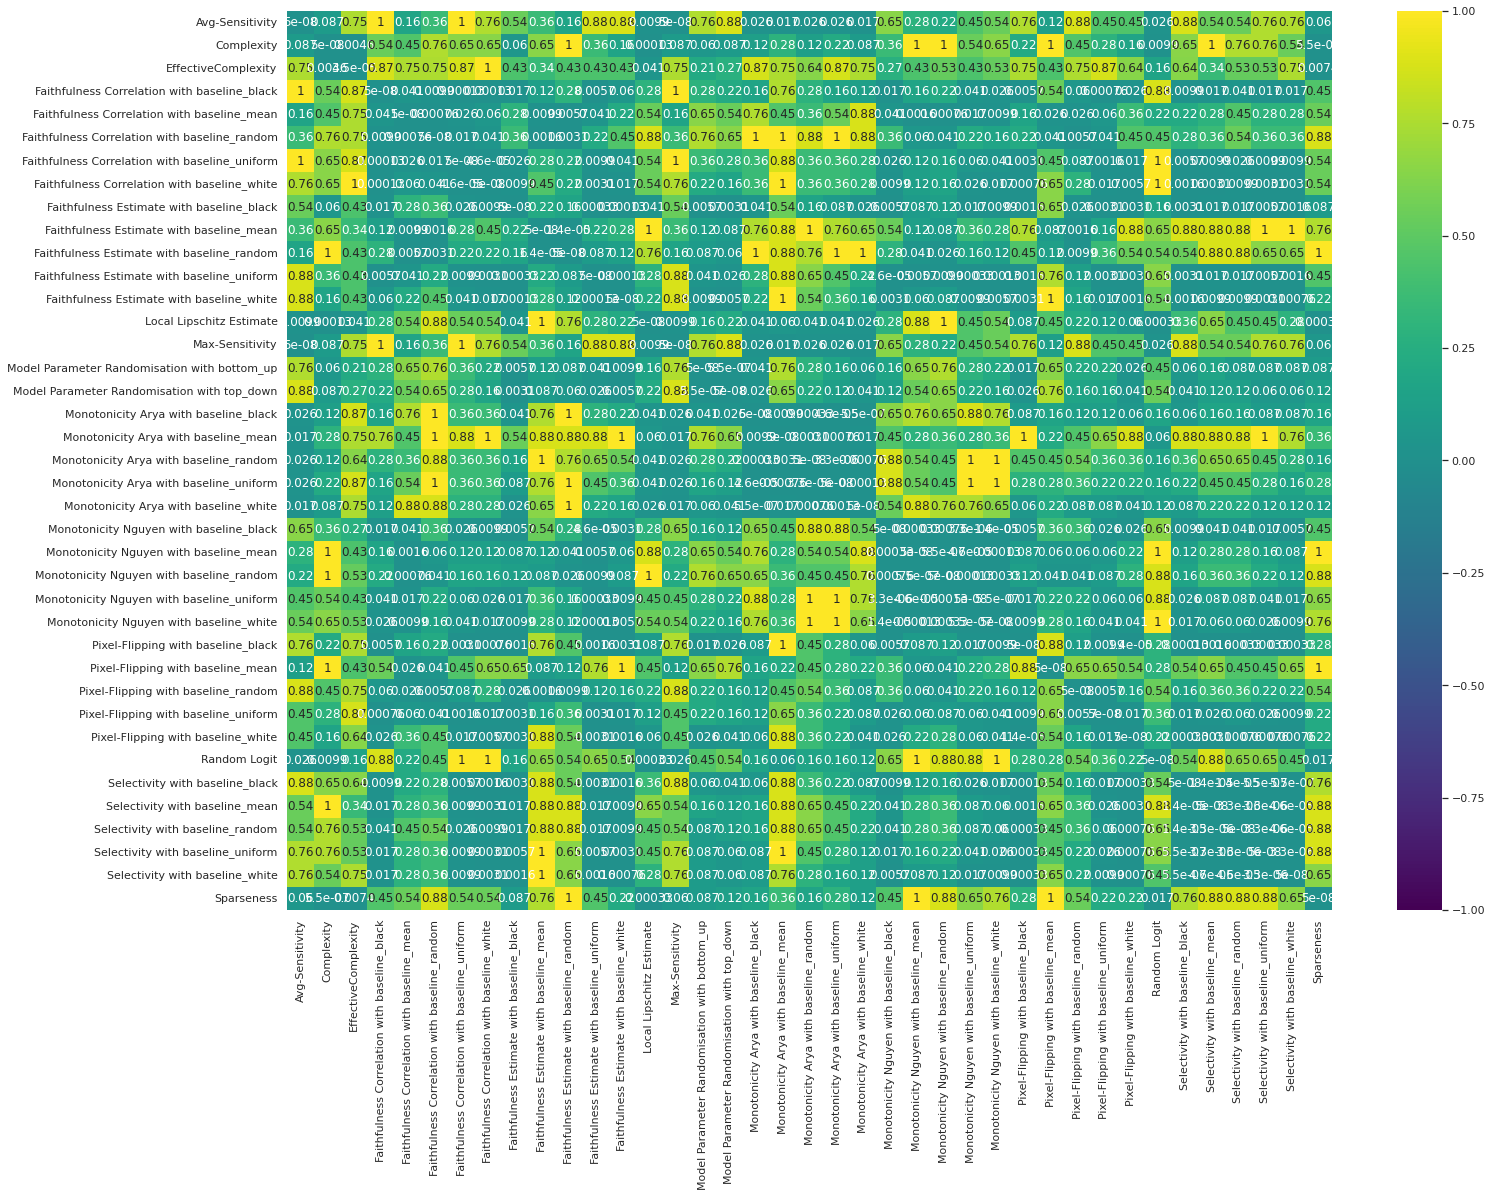

In [23]:
# Matrix of the p_values
sn.heatmap(p_values,
           annot=True,
           vmin=-1,
           vmax=1,
           xticklabels=metrics_with_baselines,
           yticklabels=metrics_with_baselines,
           cmap='viridis')
plt.show()

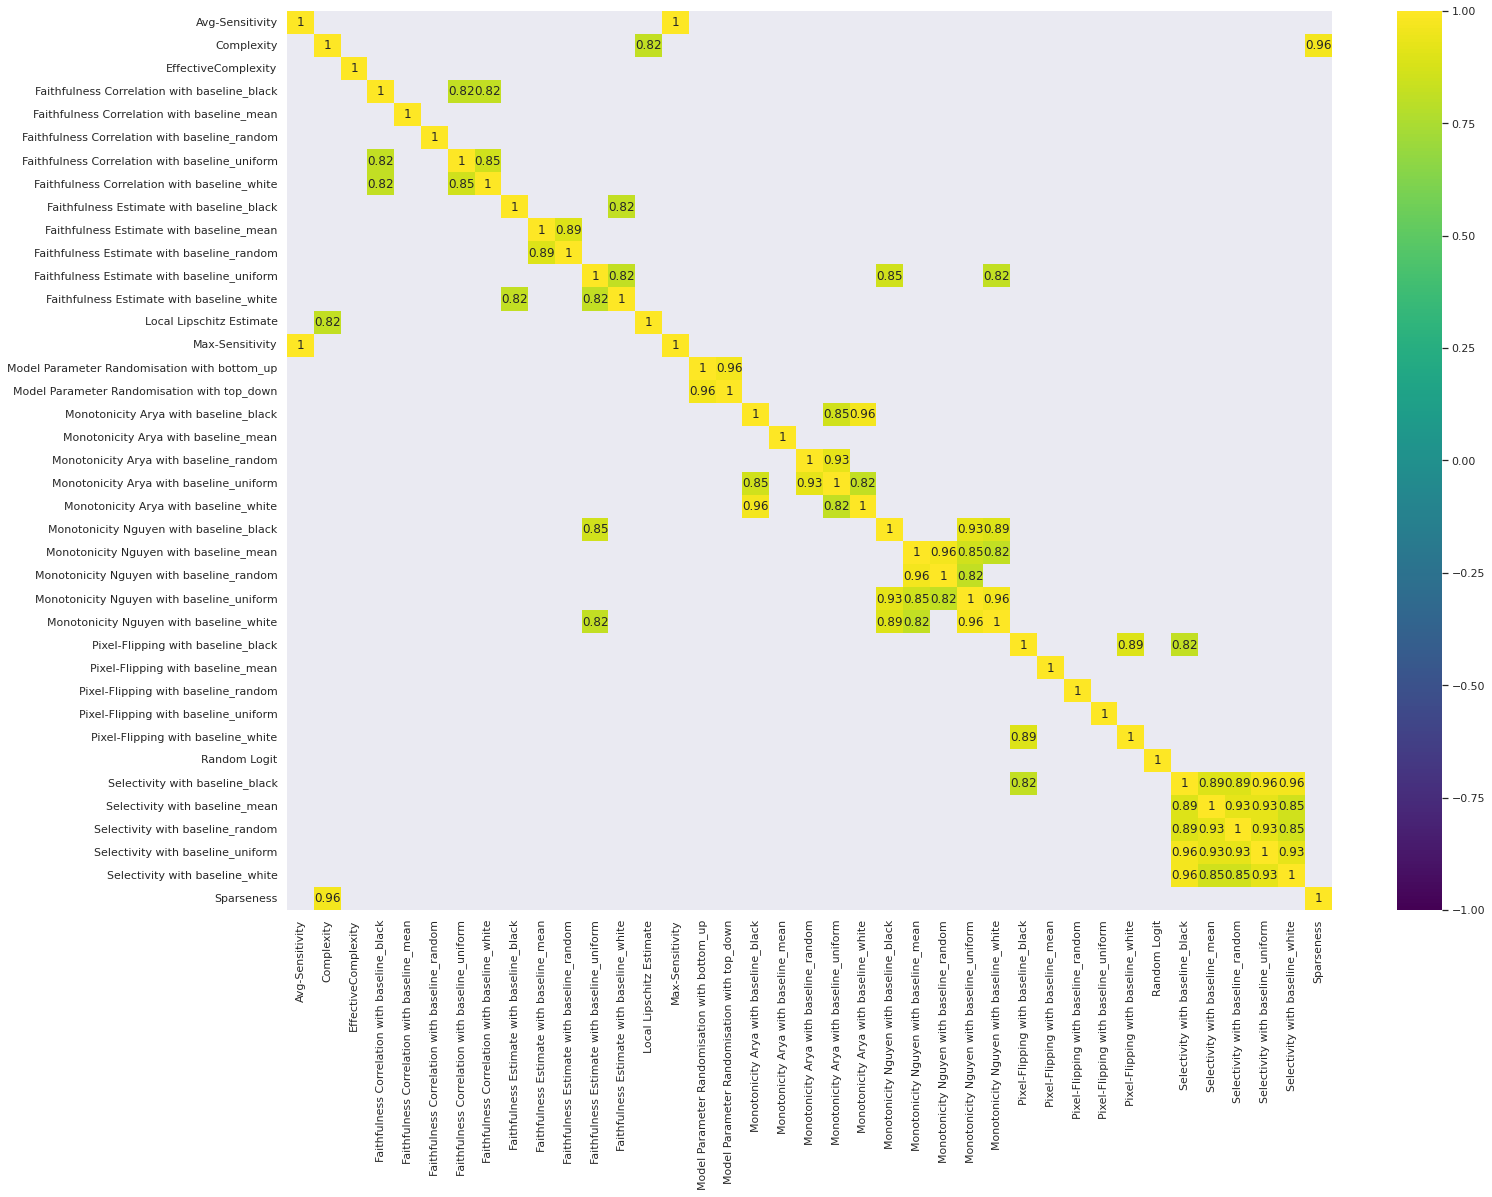

In [27]:
# Correlation Matrix with only significative values (Bonferroni Correction)
p_threshold = 0.05 / len(metrics) ** 2 
p_values_mask = []
for sublist in p_values:
    p_values_mask.append([p_value > p_threshold for p_value in sublist])
    
p_values_mask = np.array(p_values_mask)

sn.heatmap(tau_values,
           annot=True,
           vmin=-1,
           vmax=1,
           xticklabels=metrics_with_baselines,
           yticklabels=metrics_with_baselines,
           mask=p_values_mask,
           cmap='viridis')
plt.savefig('./results/corr_matrix_avg_aggreg_bonferroni_corr.png')
plt.show()

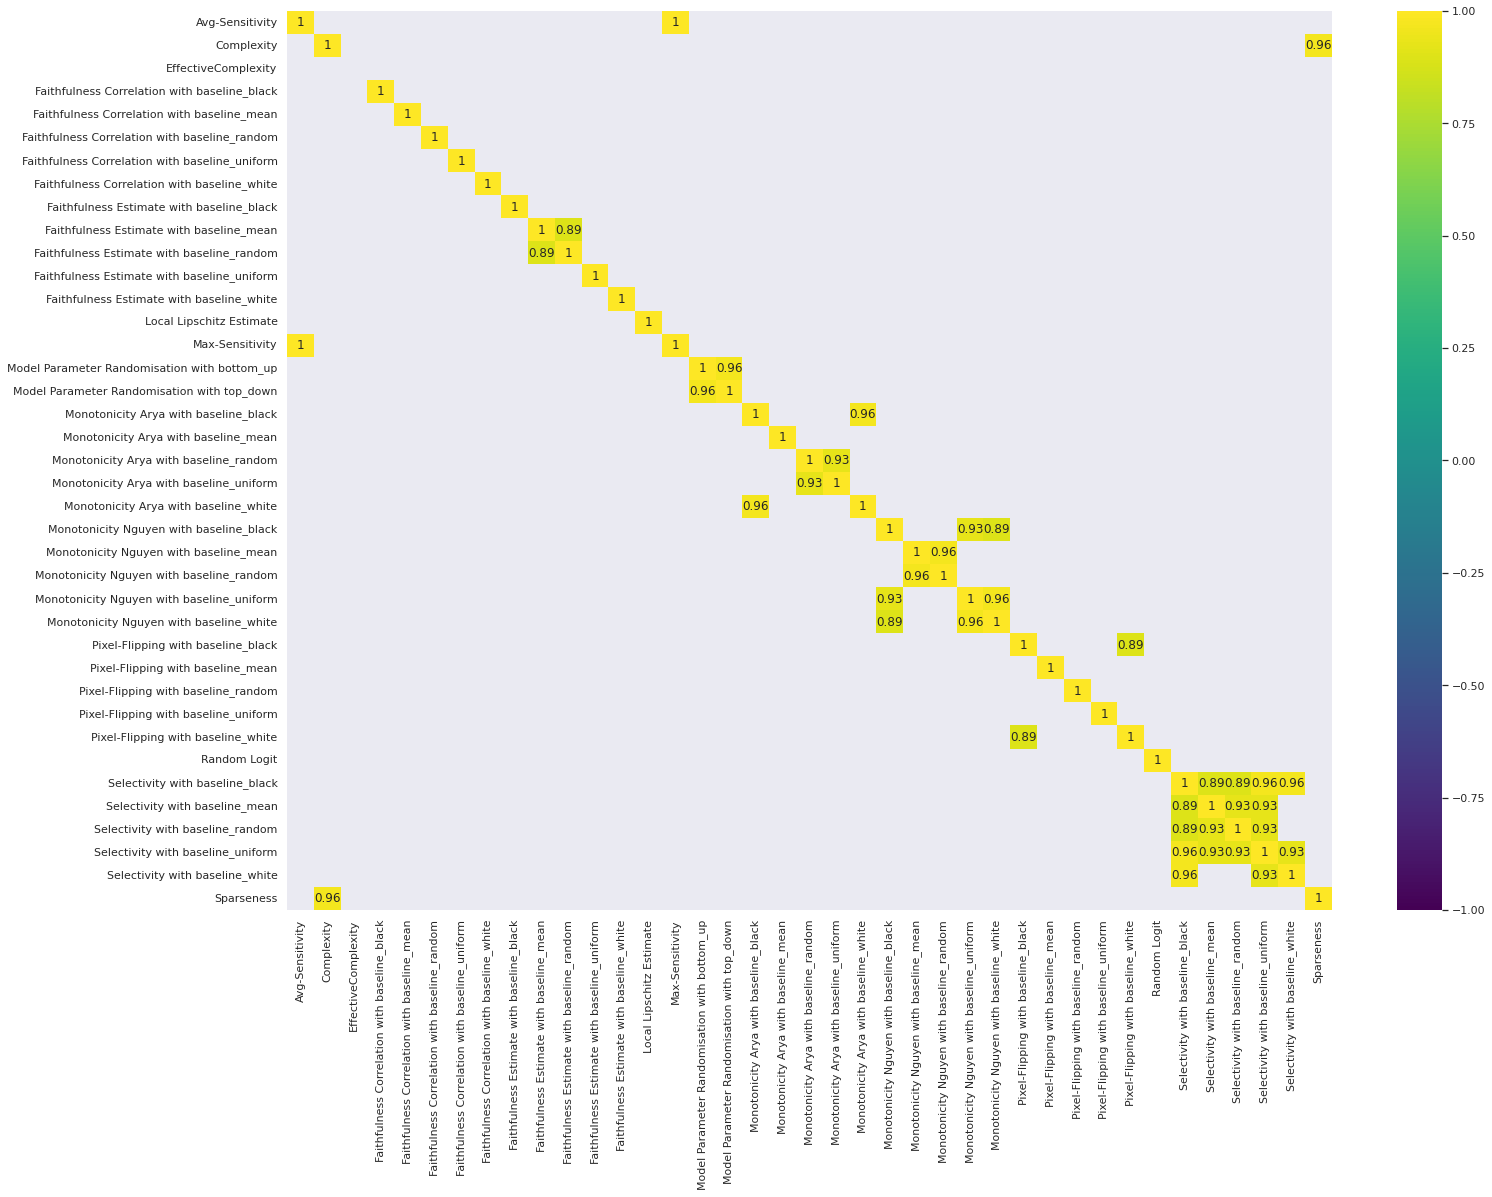

In [28]:
# Correlation Matrix with only significative values (Holm Correction)
from statsmodels.stats.multitest import multipletests

p_values_flattened = [p_value for sublist in p_values for p_value in sublist]
reject, pvals_corrected, _, alphacBonf = multipletests(p_values_flattened,
                                                       alpha=0.05,
                                                       method='holm')

sn.heatmap(tau_values,
           annot=True,
           vmin=-1,
           vmax=1,
           xticklabels=metrics_with_baselines,
           yticklabels=metrics_with_baselines,
           mask=np.invert(reject).reshape((len(metrics_with_baselines),len(metrics_with_baselines))),
           cmap='viridis')
plt.savefig('./results/corr_matrix_avg_aggreg_holm_corr.png')
plt.show()